#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 1s 0us/step


Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:** [TO COMPLETE]

The problem we're are addressing with this RNN belongs to the binary classification problems, where we have to say whether something belongs to a class or not, e.g. in sentiment analysis whether a statement is positive or negative. In order to compare what is obtained from the network and the target, given a statement, the targets are converted in numbers, so positive is 1 and negative is 0. For this reason, the Dense layer at the end has a number of units equal to **1** (the result) which is passed through the **sigmoid** activation function, whose codomain is $[0, 1]$, to produce an output of the network which is close to the target ones. 

As loss function I chose **binary_crossentropy**, because it's the intended one to be used in case of binary classification and the target values are in the set $\{0, 1\}$. There is also another cross entropy function which is suitable for binary classification, that is Hinge, but the target value are intened to be in the set $\{-1, 1\}$. Anyway, I could have used Hinge instead of binary_crossentropy, since the tensorflow implementation of it converts the target values from $\{0, 1\}$ to $\{-1, 1\}$ automatically, but theoretically binary_crossentropy is the recommended one in this case.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(units=32)) # [TO COMPLETE]
model.add(keras.layers.Dense(units=1, activation="sigmoid")) # [TO COMPLETE]

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # [TO COMPLETE] 

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_162 (Embedding)   (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense_324 (Dense)           (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 59s 293ms/step - loss: 0.6665 - accuracy: 0.5909 - val_loss: 0.6483 - val_accuracy: 0.6122
Epoch 2/10
196/196 [==============================] - 52s 268ms/step - loss: 0.4975 - accuracy: 0.7594 - val_loss: 0.3889 - val_accuracy: 0.8321
Epoch 3/10
196/196 [==============================] - 53s 269ms/step - loss: 0.2971 - accuracy: 0.8797 - val_loss: 0.3392 - val_accuracy: 0.8606
Epoch 4/10
196/196 [==============================] - 53s 269ms/step - loss: 0.2310 - accuracy: 0.9120 - val_loss: 0.3561 - val_accuracy: 0.8490
Epoch 5/10
196/196 [==============================] - 52s 266ms/step - loss: 0.1632 - accuracy: 0.9419 - val_loss: 0.4070 - val_accuracy: 0.8526
Epoch 6/10
196/196 [==============================] - 53s 270ms/step - loss: 0.1089 - accuracy: 0.9648 - val_loss: 0.4222 - val_accuracy: 0.8485
Epoch 7/10
196/196 [==============================] - 53s 271ms/step - loss: 0.0757 - accuracy: 0.9782 - val_loss: 0.4662 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

391/391 - 8s - loss: 0.5501 - accuracy: 0.8471 - 8s/epoch - 20ms/step
accuracy: 84.71%


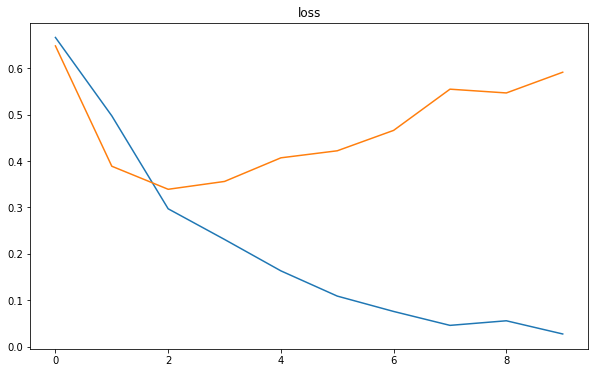

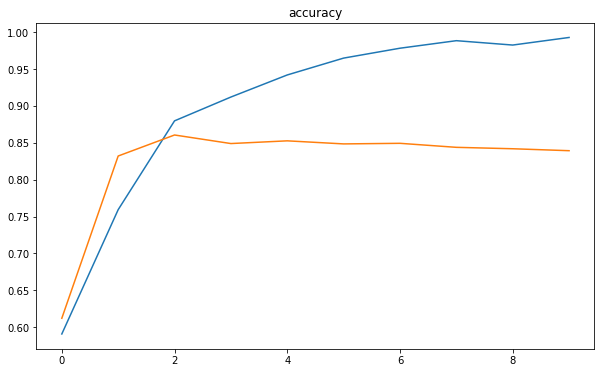

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

---

With the same number of units, the LSTM model is better in term of performance with $84.83\%$ then the GRU one which is a simpler version of it and reaches an accuracy of $84.46\%$. In term of number of parameters, the GRU model has a lower number since it has less gates, i.e. 2 gates (update and reset gates) compared to the 3 ones of LSTM (input, output and forget gates), and for this reason it's faster in term of training time.

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_128 (Embedding)   (None, None, 10)          100000    
                                                                 
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense_256 (Dense)           (None, 1)                 65        
                                                                 
Total params: 119,265
Trainable params: 119,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 8s 16ms/step - loss: 0.4934 - accuracy: 0.7382 - val_loss: 0.3719 - val_accuracy: 0.8462
Epoch 2/10
196/196 [==============================] - 3s 15ms/step - loss: 0.2569 - accuracy: 0.9011 - val_loss: 0.3019 - val_accuracy: 0.8778
Epoch 3/10
196/196 [=====

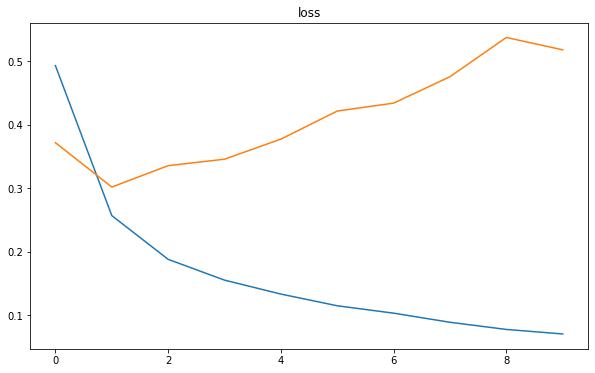

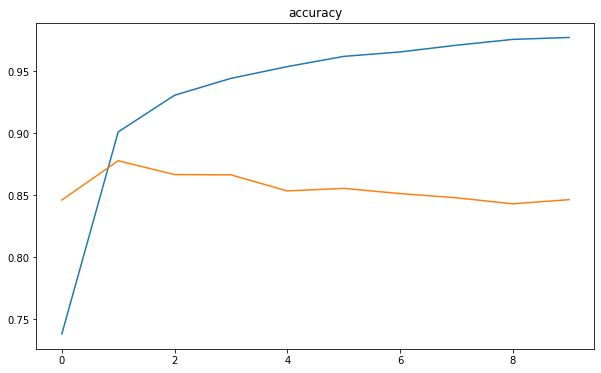

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.
model_lstm = keras.models.Sequential([
  keras.layers.Embedding(input_dim=num_words, output_dim=10),
  keras.layers.LSTM(units=64),
  keras.layers.Dense(1, activation="sigmoid")
])

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_lstm.summary()

history = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_130 (Embedding)   (None, None, 10)          100000    
                                                                 
 gru_1 (GRU)                 (None, 64)                14592     
                                                                 
 dense_258 (Dense)           (None, 1)                 65        
                                                                 
Total params: 114,657
Trainable params: 114,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 5s 16ms/step - loss: 0.4663 - accuracy: 0.7618 - val_loss: 0.3335 - val_accuracy: 0.8606
Epoch 2/10
196/196 [==============================] - 2s 12ms/step - loss: 0.2440 - accuracy: 0.9045 - val_loss: 0.3162 - val_accuracy: 0.8640
Epoch 3/10
196/196 [=====

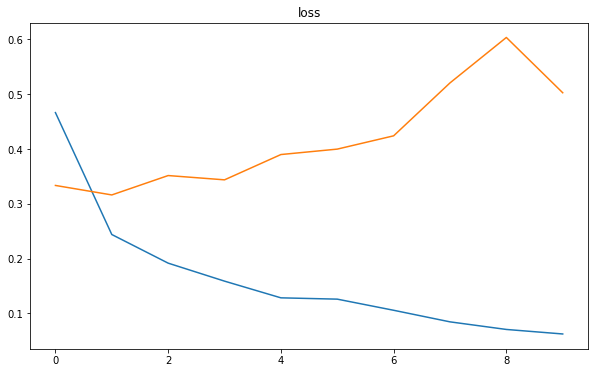

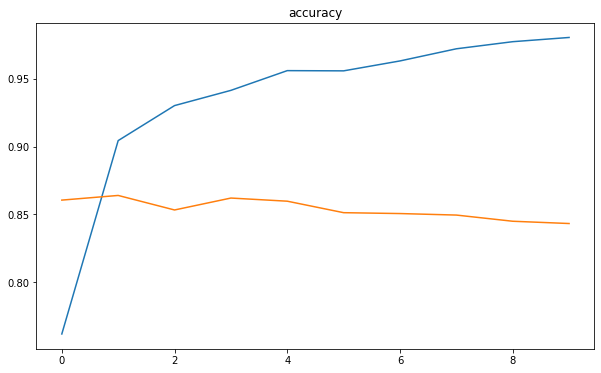

In [ ]:
# GRU - complete with model definition, summary, fit and plots.
model_gru = keras.models.Sequential([
  keras.layers.Embedding(input_dim=num_words, output_dim=10),
  keras.layers.GRU(units=64),
  keras.layers.Dense(1, activation="sigmoid")
])

model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_gru.summary()

history = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm_1 (LSTM)               (None, 14)                1400      
                                                                 
 dense_3 (Dense)             (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 20s 92ms/step - loss: 0.5265 - accuracy: 0.7374 - val_loss: 0.3609 - val_accuracy: 0.8566
Epoch 2/10
196/196 [==============================] - 18s 89ms/step - loss: 0.2848 - accuracy: 0.8934 - val_loss: 0.3139 - val_accuracy: 0.8688
Epoch 3/10
196/196 [====

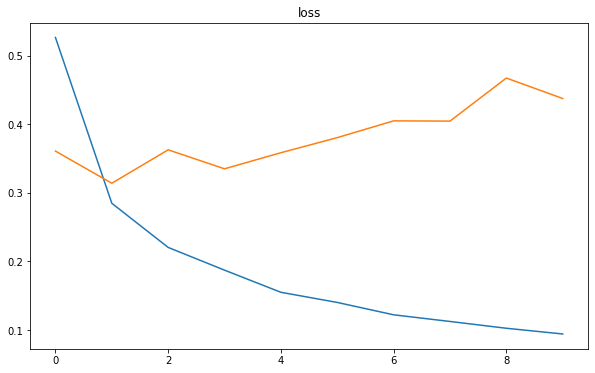

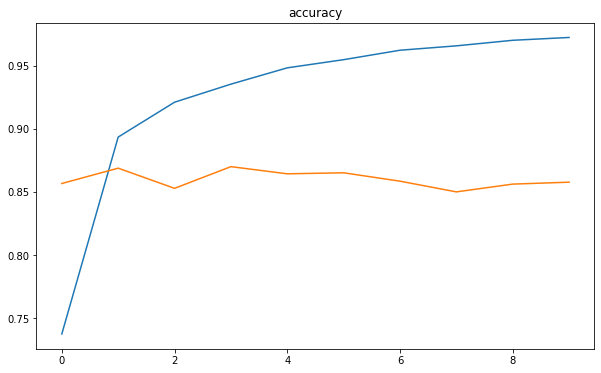

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.
model_lstm = keras.models.Sequential([
  keras.layers.Embedding(input_dim=num_words, output_dim=10),
  keras.layers.LSTM(units=14),
  keras.layers.Dense(1, activation="sigmoid")
])

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_lstm.summary()

history = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru_1 (GRU)                 (None, 16)                1344      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 20s 92ms/step - loss: 0.5739 - accuracy: 0.6765 - val_loss: 0.3934 - val_accuracy: 0.8322
Epoch 2/10
196/196 [==============================] - 18s 89ms/step - loss: 0.3145 - accuracy: 0.8710 - val_loss: 0.3340 - val_accuracy: 0.8632
Epoch 3/10
196/196 [====

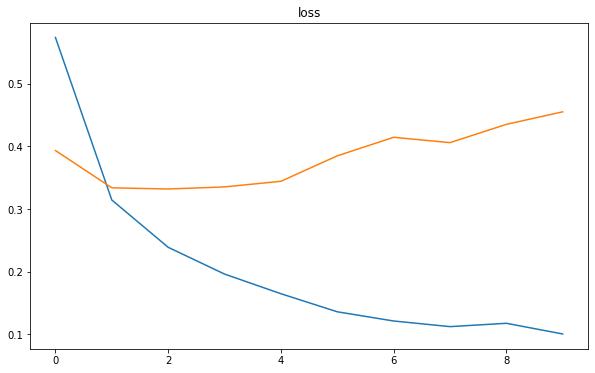

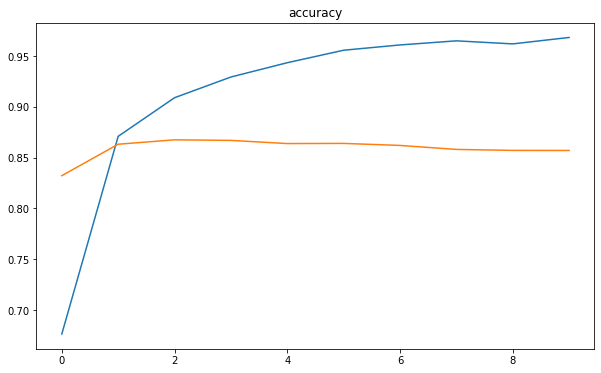

In [ ]:
# GRU - complete with model definition, summary, fit and plots.
model_gru = keras.models.Sequential([
  keras.layers.Embedding(input_dim=num_words, output_dim=10),
  keras.layers.GRU(units=16),
  keras.layers.Dense(1, activation="sigmoid")
])

model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_gru.summary()

history = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))

Since we have to use more or less the same number of parameters of the RNN model, we have to calculate how many units for the recurrent layers we need, since the parameters used in the Embedding layer are always the same while in the Dense layer are almost the same.

Let me introduce some notations in order to explain better how the number of parameters is obtained for SimpleRNN, LSTM and GRU layers:
- $n$: dimension of hidden layer;
- $k$: dimension of output layer;
- $m$: dimension of input layer.

The values of $k$ and $m$ are $1$ and $10$, the same for all the three models. What changes is the dimension of hidden layer. Let's see the formulas for each layer:

- SimpleRNN: $n^2 + kn + nm$. In our model $n = 32$, indeed the number of parameters of the SimpleRNN layer is $1376 = 32^2 + 1 \cdot 32 + 32 \cdot 10$;
- LSTM: $4(n^2 + n + nm)$;
- GRU: $3(n^2 + 2n + nm)$.

Hence, to find the exact number of units for the LSTM layer, in order to get the same number of parameters as the SimpleRNN layer, we need to solve the following equation:

$4(n^2 + n + 10n) = 1376$, 

whose positive solution rounded to the nearest integer is $n \approx 14$.

The work is analogous for the GRU layer:

$3(n^2 + 2n + 10n) = 1376$,

whose positive solution rounded to the nearest integer is $n \approx 16$.

Finally, I can discuss the differences among the three models in terms of performance, number of parameters and training time. 

Regarding the performance, the best model is the LSTM one with $85.89\%$, then there is the GRU model which reached a very similar performance with $85.86\%$ and the worst is the RNN one with $84.71\%$.

Speaking about number of parameters, the model with less parameters is the GRU one with $101,361$, as expected from the theory since it uses less of them, compared to the RNN one with $101,409$ and the LSTM one with $101,415$.

Watching the training time, the RNN model is the slower with $55s$ per epoch, while the GRU one is the faster with $19s$ per epoch. The LSTM model is slightly slower then the GRU one with $20s$ per epoch.

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 42s 195ms/step - loss: 0.6377 - accuracy: 0.6898 - val_loss: 0.4615 - val_accuracy: 0.8179
Epoch 2/5
196/196 [==============================] - 38s 193ms/step - loss: 0.3907 - accuracy: 0.8428 

391/391 - 5s - loss: 0.3553 - accuracy: 0.8733 - 5s/epoch - 13ms/step
accuracy: 87.33%


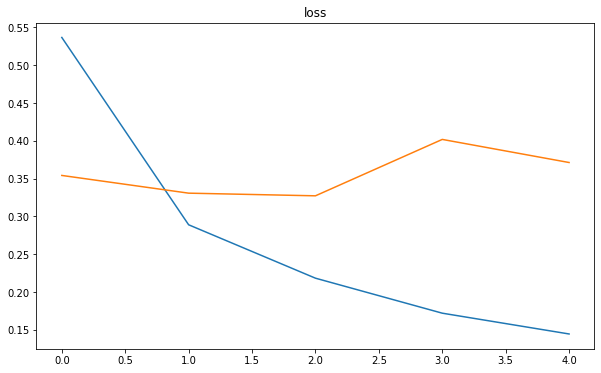

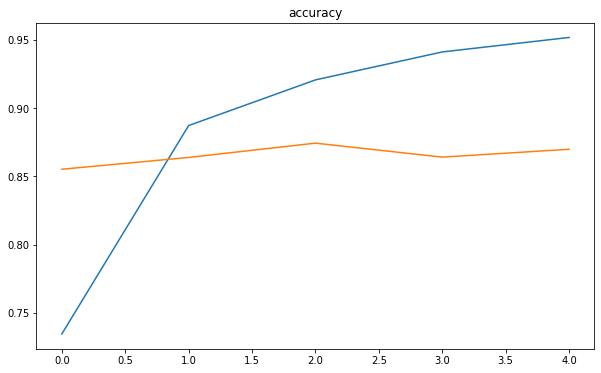

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [ ]:
from timeit import default_timer as timer
from keras.callbacks import Callback

class TimingCallback(Callback):
    def __init__(self, logs={}):
      self.training_time = 0
      self.n_epochs = 0

    def on_train_begin(self, logs={}):
      self.training_time = 0
      self.n_epochs = 0

    def on_epoch_begin(self, epoch, logs={}):
      self.starttime = timer()
      self.n_epochs += 1

    def on_epoch_end(self, epoch, logs={}):
      self.training_time += timer()-self.starttime

    def on_train_end(self, logs={}):
      self.mean_training_time = round(self.training_time / self.n_epochs, 4)

In [ ]:
time_callback = TimingCallback()

def build_and_evaluate_model(embed_dim, num_heads, ff_dim):
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
  history = model.fit(
      X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid), callbacks=[time_callback]
  )

  scores = model.evaluate(X_test_trim, y_test, verbose=2)

  return history, scores, time_callback.mean_training_time

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')
  plt.show()

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')
  plt.show()

def print_information(history, accuracy, mean_training_times, embed_dim, num_heads, ff_dim):
  print("="*180)
  print("Model with:")
  print(f'- Embed dim: {embed_dim}')
  print(f'- Num heads: {num_heads}')
  print(f'- FF dim: {ff_dim}')
  print("Accuracy: %.2f%%" % (accuracy*100))
  print(f"Training time/epoch: {mean_training_times}(s)")
  plot_loss(history)
  plot_accuracy(history)

In [ ]:
embed_dims = [8, 16, 24, 32]
nums_heads = [1, 7, 15, 64]
ff_dims = [8, 16, 24, 32]

accuracies = []
mean_training_times = []

for embed_dim in embed_dims:
  for num_heads in nums_heads:
    for ff_dim in ff_dims:
      history, scores, mean_training_time = build_and_evaluate_model(embed_dim, num_heads, ff_dim)
      print_information(history, scores[1], mean_training_time, embed_dim, num_heads, ff_dim)

      accuracies.append(scores[1]*100)
      mean_training_times.append(mean_training_time)

for i, embed_dim in enumerate(embed_dims):
  for j, num_heads in enumerate(nums_heads):
    for z, ff_dim in enumerate(ff_dims):
      k = i*len(nums_heads)*len(ff_dims) + j*len(nums_heads) + z
      print(f'({embed_dim}, {num_heads}, {ff_dim}): {accuracies[k]}, {mean_training_times[k]}(s)')

Output hidden; open in https://colab.research.google.com to view.

**Insert the discussion here**: [TO COMPLETE]

First of all, let me explain how I tried the different values for the model. I created the function **build_and_evaluate_model** which given embed_dim, num_heads and ff_dim builds and evaluates the model and returns the history, the scores and the training time per epoch. The training time is got through an object of class **TimingCallback**, that computes the average training time and it's called by the fit method as callback. Then, I print all the information, i.e. accurancy and training time x epoch, and I save them in two lists.

I tried all the combinations with the following values:
- embed_dims: $[8, 16, 24, 32]$
- nums_heads:$[1, 7, 15, 64]$
- ff_dims: $[8, 16, 24, 32]$

i.e. all the triples belong to $\{(i, j, k) \mid \forall i \in embed\_dims, \forall j \in nums\_heads, \forall k \in ff\_dims \}$, and then I printed the results to analyze them.

As can be seen, the training time per epoch increases by increasing the number of heads and the feedforward dimension, since more heads we have, we end up having more parameters to learn and this definetly increase the training time per epoch.

The accuracy is in general very high with any possible combination, but it's better when the number of heads is low. The other two hyperparameters don't seem to affect the accuracy in an important way.